# Лабораторная работа №1 Vision transformer
# Фазылова Алика 5140201/30301


## **Задание 1** Реализуем архитектуру трансформера


Установим необходимые пакеты:


In [1]:
!pip install einops
!pip install torch torchvision
!pip install torchsummary
!pip install torchvision --user

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

импортируем библиотеки:

In [2]:
import torch
import torch.nn.functional as F
from torch import Tensor, nn
from torchsummary import summary
from torchvision.transforms import Compose, Resize, ToTensor

from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from PIL import Image
import matplotlib.pyplot as plt

Используем некоторое изображение для проверки:

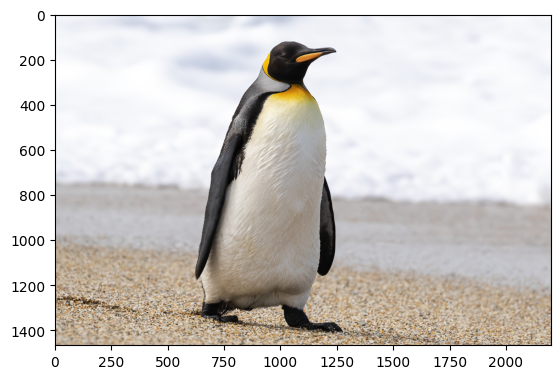

In [3]:
import matplotlib.pyplot as plt
from PIL import Image
#изображение для проверки
img = Image.open('/content/penguin.jpg')

fig = plt.figure()
plt.imshow(img)
plt.show()

Приведем изображение к нужному размеру 224х224 пикселя. Препроцессинг:

In [4]:
#препроцессинг
trans = Compose([
  Resize((224, 224)),
  ToTensor(),
])

x = trans(img)
x = x.unsqueeze(0)
print(x.shape)
torch.Size([1,3,224,224])

torch.Size([1, 3, 224, 224])


torch.Size([1, 3, 224, 224])

класс PatchEmbedding

In [5]:
#создается последовательность эмбедингов, которые являются входом кодировщика
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16,
emb_size: int = 768,img_size: int=224):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size,
stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'),
        ) # разбивает изображение на патчи s1xs2, а затем сглаживает их
        self.cls_token = nn.Parameter(torch.randn(1,1, emb_size))
        self.positions = nn.Parameter(torch.randn((img_size // patch_size)
**2 + 1, emb_size))

    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        x = torch.cat([cls_tokens, x], dim=1) #добавляет эмбединги позиций
        x += self.positions
        return x

Реализуем механизм внимания:

In [6]:
#механизм внимания
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 768, num_heads: int = 8, dropout:
float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.qkv = nn.Linear(emb_size, emb_size * 3) # queries, keys and values matrix
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)

    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        # split keys, queries and values in num_heads
        qkv = rearrange(self.qkv(x), "b n (h d qkv) -> (qkv) b h n d",
h=self.num_heads, qkv=3)
        queries, keys, values = qkv[0], qkv[1], qkv[2]
        # sum up over the last axis
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys)

        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)

        scaling = self.emb_size ** (1/2)

        att = F.softmax(energy, dim=-1) / scaling
        att = self.att_drop(att)
        out = torch.einsum('bhal, bhlv -> bhav ', att, values) # sum over the third axis
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)

        return out

Реализуем shortcut connection:

In [7]:
#shortcut connection
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

Реализуем полносвязный слой:

In [8]:
#полносвязный слой
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size: int, L: int = 4, drop_p: float = 0.):
        super().__init__(
            nn.Linear(emb_size, L * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(L * emb_size, emb_size),
        )

Реализуем кодировщик (Encoder) трансформера:

In [9]:
#transformer encoder блок
class TransformerEncoderBlock(nn.Sequential):
    def __init__(self, emb_size: int = 768, drop_p: float = 0.,
forward_expansion: int = 4,
                 forward_drop_p: float = 0.,
                 **kwargs):

        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, **kwargs),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, L=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))

используем несколько Encoder блоков:

In [10]:
#несколько encoder блоков
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth: int = 12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in
range(depth)])

Реализуем классификатор:

In [11]:
#классификатор
class ClassificationHead(nn.Sequential):
  def __init__(self, emb_size: int = 768, n_classes: int = 1000):
    super().__init__(
      Reduce('b n e -> b e', reduction='mean'),
      nn.LayerNorm(emb_size),
      nn.Linear(emb_size, n_classes))

Реализуем архитектуру Vision Transformer:

In [12]:
#vision transformer
class ViT(nn.Sequential):
  def __init__(self,
              in_channels: int = 3,
              patch_size: int = 16,
              emb_size: int = 768,
              img_size: int = 224,
              depth: int = 12,
              n_classes: int = 1000,
              **kwargs):
      super().__init__(
          PatchEmbedding(in_channels, patch_size, emb_size, img_size),
          TransformerEncoder(depth, emb_size=emb_size, **kwargs),
          ClassificationHead(emb_size, n_classes)
      )

Проверим корректность реализации:

In [13]:
print(summary(ViT(), (3,224,224), device='cpu'))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
         Rearrange-2             [-1, 196, 768]               0
    PatchEmbedding-3             [-1, 197, 768]               0
         LayerNorm-4             [-1, 197, 768]           1,536
            Linear-5            [-1, 197, 2304]       1,771,776
           Dropout-6          [-1, 8, 197, 197]               0
            Linear-7             [-1, 197, 768]         590,592
MultiHeadAttention-8             [-1, 197, 768]               0
           Dropout-9             [-1, 197, 768]               0
      ResidualAdd-10             [-1, 197, 768]               0
        LayerNorm-11             [-1, 197, 768]           1,536
           Linear-12            [-1, 197, 3072]       2,362,368
             GELU-13            [-1, 197, 3072]               0
          Dropout-14            [-1, 19

## Задание №2 Обучение vision transformer

В качестве исходных данных используем CIFAR-10.  
Набор данных CIFAR-10 состоит из 60000 цветных изображений
размером 32x32 пикселя, каждое изображение относится к одному из 10
классов, по 6000 изображений в каждом классе. Есть 50000 обучающих
изображений и 10000 тестовых изображений.


Для обучение будет использовать GPU

Проверим среду выполнения:

In [14]:
#проверка,что на GPU
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

импортируем библиотеки:

In [15]:
#импорт библиотек
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.cuda.amp import autocast, GradScaler

Зададим параметры обучения:

In [16]:
# Задаем параметры обучения
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 20
batch_size = 32
learning_rate = 0.001

Загрузим набор данных CIFAR-10. Данные необходимо
нормализировать:

In [17]:
# Загружаем CIFAR-10 датасет, преобразуем размер и нормализируем
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:03<00:00, 49295013.60it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Для обучения необходимо реализовать загрузчики данных. Так, для
каждой эпохи обучения будет выбираться пакет размером batch_size
случайных изображений из обучающей выборки и передаваться в качестве
входных данных.

In [18]:
# Создаем загрузчики данных
train_loader = DataLoader(train_dataset, batch_size=batch_size,
shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size,
shuffle=False, num_workers=2)

Теперь, инициализируем саму модель Vision Transformer.
Инициализируем метод обучения, функцию потерь и функцию, которая
позволяет автоматически масштабировать градиенты:

In [19]:
# Инициализируем модель и оптимизатор
model = ViT(in_channels=3,patch_size=4,emb_size=64,img_size=32,depth=12,n_classes=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
# Инициализируем GradScaler для автоматического масштабирования градиентов
scaler = GradScaler()

Обучим модель на 20 эпохах, при размере пакета 32 и
скорости обучения 0.001. Код обучения:

In [20]:
# Обучение модели
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

    # Вывод промежуточных результатов
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [1/20], Loss: 1.7126
Epoch [2/20], Loss: 1.3908
Epoch [3/20], Loss: 1.2569
Epoch [4/20], Loss: 1.1645
Epoch [5/20], Loss: 1.0907
Epoch [6/20], Loss: 1.0372
Epoch [7/20], Loss: 0.9885
Epoch [8/20], Loss: 0.9451
Epoch [9/20], Loss: 0.9120
Epoch [10/20], Loss: 0.8813
Epoch [11/20], Loss: 0.8550
Epoch [12/20], Loss: 0.8275
Epoch [13/20], Loss: 0.8082
Epoch [14/20], Loss: 0.7878
Epoch [15/20], Loss: 0.7754
Epoch [16/20], Loss: 0.7542
Epoch [17/20], Loss: 0.7361
Epoch [18/20], Loss: 0.7261
Epoch [19/20], Loss: 0.7166
Epoch [20/20], Loss: 0.6987


## Задание №3 Тестирование Vision Transformer

Протестируем обученную модель на данных из тестирующей выборки.
Код тестирования:

In [21]:
# Оценка модели
model.eval()
total_correct = 0
total_samples = 0

with torch.no_grad():
  for images, labels in test_loader:
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)
      _, predicted = torch.max(outputs, 1)

      total_samples += labels.size(0)
      total_correct += (predicted == labels).sum().item()

accuracy = total_correct / total_samples * 100
print(f"Accuracy on test set: {accuracy:.2f}%")

Accuracy on test set: 66.13%


## Задание 4 Изменить каждый из параметров обучения (количество эпох, размер пакета, начальная скорость обучения), повторить пункты 2 и 3.

## Количество эпох

Увеличим количество эпох от изначального.Обучим модель на 25 эпохах, при размере пакета 32 и скорости обучения 0.001.

In [38]:
num_epochs = 25
batch_size = 32
learning_rate = 0.001

In [39]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [40]:
model = ViT(in_channels=3,patch_size=4,emb_size=64,img_size=32,depth=12,n_classes=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
scaler = GradScaler()

In [41]:
# Обучение модели
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

    # Вывод промежуточных результатов
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

Epoch [1/25], Loss: 1.7459
Epoch [2/25], Loss: 1.3972
Epoch [3/25], Loss: 1.2486
Epoch [4/25], Loss: 1.1533
Epoch [5/25], Loss: 1.0771
Epoch [6/25], Loss: 1.0185
Epoch [7/25], Loss: 0.9706
Epoch [8/25], Loss: 0.9310
Epoch [9/25], Loss: 0.8977
Epoch [10/25], Loss: 0.8652
Epoch [11/25], Loss: 0.8420
Epoch [12/25], Loss: 0.8183
Epoch [13/25], Loss: 0.7988
Epoch [14/25], Loss: 0.7739
Epoch [15/25], Loss: 0.7580
Epoch [16/25], Loss: 0.7354
Epoch [17/25], Loss: 0.7211
Epoch [18/25], Loss: 0.7060
Epoch [19/25], Loss: 0.6944
Epoch [20/25], Loss: 0.6833
Epoch [21/25], Loss: 0.6668
Epoch [22/25], Loss: 0.6585
Epoch [23/25], Loss: 0.6514
Epoch [24/25], Loss: 0.6349
Epoch [25/25], Loss: 0.6335


In [42]:
# Оценка модели
model.eval()
total_correct = 0
total_samples = 0

with torch.no_grad():
  for images, labels in test_loader:
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)
      _, predicted = torch.max(outputs, 1)

      total_samples += labels.size(0)
      total_correct += (predicted == labels).sum().item()

accuracy = total_correct / total_samples * 100
print(f"Accuracy on test set: {accuracy:.2f}%")

Accuracy on test set: 66.67%


видно что точность модели немного повысилась

## Размер пакета

Модель с 25 эпохами показывает более высокую точность однако обучение происходит довольно долго увеличим размер пакета до 128

In [43]:
num_epochs = 25
batch_size = 128
learning_rate = 0.001

In [44]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [45]:
model = ViT(in_channels=3,patch_size=4,emb_size=64,img_size=32,depth=12,n_classes=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
scaler = GradScaler()

In [46]:
# Обучение модели
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

    # Вывод промежуточных результатов
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

Epoch [1/25], Loss: 1.8199
Epoch [2/25], Loss: 1.4182
Epoch [3/25], Loss: 1.2617
Epoch [4/25], Loss: 1.1668
Epoch [5/25], Loss: 1.0839
Epoch [6/25], Loss: 1.0157
Epoch [7/25], Loss: 0.9512
Epoch [8/25], Loss: 0.9041
Epoch [9/25], Loss: 0.8465
Epoch [10/25], Loss: 0.8028
Epoch [11/25], Loss: 0.7525
Epoch [12/25], Loss: 0.7174
Epoch [13/25], Loss: 0.6718
Epoch [14/25], Loss: 0.6306
Epoch [15/25], Loss: 0.5923
Epoch [16/25], Loss: 0.5564
Epoch [17/25], Loss: 0.5100
Epoch [18/25], Loss: 0.4939
Epoch [19/25], Loss: 0.4478
Epoch [20/25], Loss: 0.4187
Epoch [21/25], Loss: 0.3880
Epoch [22/25], Loss: 0.3682
Epoch [23/25], Loss: 0.3349
Epoch [24/25], Loss: 0.3122
Epoch [25/25], Loss: 0.2954


In [47]:
# Оценка модели
model.eval()
total_correct = 0
total_samples = 0

with torch.no_grad():
  for images, labels in test_loader:
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)
      _, predicted = torch.max(outputs, 1)

      total_samples += labels.size(0)
      total_correct += (predicted == labels).sum().item()

accuracy = total_correct / total_samples * 100
print(f"Accuracy on test set: {accuracy:.2f}%")

Accuracy on test set: 64.08%


скорость обучения возросла, но точность немного упала

## Скорость обучения

Изменим скорость обучения с 0.001 до 0.0001

In [48]:
num_epochs = 25
batch_size = 128
learning_rate = 0.0001

In [49]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [50]:
model = ViT(in_channels=3,patch_size=4,emb_size=64,img_size=32,depth=12,n_classes=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
scaler = GradScaler()

In [51]:
# Обучение модели
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

    # Вывод промежуточных результатов
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

Epoch [1/25], Loss: 2.0036
Epoch [2/25], Loss: 1.7755
Epoch [3/25], Loss: 1.6531
Epoch [4/25], Loss: 1.5360
Epoch [5/25], Loss: 1.4409
Epoch [6/25], Loss: 1.3868
Epoch [7/25], Loss: 1.3355
Epoch [8/25], Loss: 1.2984
Epoch [9/25], Loss: 1.2573
Epoch [10/25], Loss: 1.2150
Epoch [11/25], Loss: 1.1849
Epoch [12/25], Loss: 1.1483
Epoch [13/25], Loss: 1.1176
Epoch [14/25], Loss: 1.0831
Epoch [15/25], Loss: 1.0579
Epoch [16/25], Loss: 1.0305
Epoch [17/25], Loss: 1.0047
Epoch [18/25], Loss: 0.9802
Epoch [19/25], Loss: 0.9572
Epoch [20/25], Loss: 0.9274
Epoch [21/25], Loss: 0.9044
Epoch [22/25], Loss: 0.8834
Epoch [23/25], Loss: 0.8591
Epoch [24/25], Loss: 0.8298
Epoch [25/25], Loss: 0.8086


In [52]:
# Оценка модели
model.eval()
total_correct = 0
total_samples = 0

with torch.no_grad():
  for images, labels in test_loader:
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)
      _, predicted = torch.max(outputs, 1)

      total_samples += labels.size(0)
      total_correct += (predicted == labels).sum().item()

accuracy = total_correct / total_samples * 100
print(f"Accuracy on test set: {accuracy:.2f}%")

Accuracy on test set: 60.67%


# Задача 5 Сравнить полученные результаты

Изначальная модель 20 эпох, 32 размер пакета,0.001 скорость обучения, точность на тестовых данных 66.13%
1. Повысив количество эпох до 25 точность немного повысилась до 66.67%, модель с повышением количества эпох (полных проходов по обучающим данным) может лучше улавливать закономерности и стабилизировать потери. Но также важно слишком большим количеством эпох не допустить переобучения. Чем больше эпох тем больше уходит времени на обучение, в нашем случае с  увеличением количество эпох время тоже увеличилось
2. взяв для модели 25 эпох, скорость обучения 0.001, увеличили размер пакета до 128, точность при этом немного понизилась до 64.08%.Однако скорость обучения значительно повысилась
3. взяв для модели 25 эпох, размер пакета 128,уменьшили скорость обучения до 0.0001.Точность при этом снизилазь до 60.67%.Это могло произойти из за того что, маленький шаг может провоцировать застревание в локальных минимумах лосс функции, и не доводить ее до оптимальных значения.Время обучения также увеличилось